In [1]:
#@title USCMS Diversity Data: Institution Statistics
#@markdown Updated `.json` files can be found from the 'statistics' tab at [icms.cern.ch](https://icms.cern.ch/tools-api/restplus/)
#@markdown This notebook includes: 
#@markdown - DICTIONARY of CMS ID : GENDER [3]
#@markdown - DICTIONARY of INSTITUTE CODE : COUNTRY [5]
#@markdown - LIST of YEARS [7]
#@markdown - DICTIONARY of INSTITUTE CODE : YEAR : CMS ACTIVITY : GENDER (ALL USA) [9]
#@markdown - LIST of desirable CMS ACTIVITIES [10]
#@markdown - LISTS of LISTS of MALE COUNTS per YEAR and FEMALE COUNTS per YEAR and INST NAMES by INST [11]
#@markdown - LIST of LISTS of ALL COUNTS then FEMALE COUNTS, both by YEAR by INST [12]
#@markdown - DATA FRAME of GENDER COUNTS per YEAR by REGION [13]
#@markdown - DATA FRAME of INDEX (A-2015 . . . F-2018) by INST by COUNT [14]
#@markdown - BAR GRAPH of GENDER COUNTS by YEAR by INSTITUTION [15]  

#@markdown _NOTE_: Put together relatively quickly, so there could be possible errors. Some regions do not seem to have CMS Activity labels all the time.

In [2]:
#@title Import pythonic libraries
#@markdown Be sure to edit the correct path to where this python notebook is stored.  The 
#@markdown base path is `/content/drive/My Drive/`, which should be edited on a user-basis.
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from collections import Counter
import ipywidgets as widgets

from google.colab import drive
drive.mount('/content/drive', force_remount = True )

sns.set(color_codes=True)
sns.set_palette("colorblind", 12)

%cd /content/drive/My Drive/Physics Research/CMS/Analysis/USCMS Diversity Data/

Mounted at /content/drive
/content/drive/My Drive/Physics Research/CMS/Analysis/USCMS Diversity Data


In [3]:
#@markdown Choose a `json` file starting with "people_stats". 
jsonFiles = widgets.SelectMultiple( options = [ option for option in sorted(os.listdir( "./Data/")) if "people_stats" in option ] )
jsonFiles

SelectMultiple(options=('people_stats_20151231.json', 'people_stats_20161231.json', 'people_stats_20171231.jso…

In [4]:
#@markdown Choose whether to display all CMS members or _only_ CMS authors
members = widgets.Select( options = [ "AUTHORS", "ALL" ] )
members

Select(options=('AUTHORS', 'ALL'), value='AUTHORS')

In [5]:
#@markdown List analysis parameters
yearlist = []
authors = True if members.value.lower() == "authors" else False

for jsonFile in jsonFiles.value:
  yearlist.append( jsonFile.split("_")[2].split(".")[0][:4] )

print( ">> Using data from the following years:" )
for year in yearlist:
  print("  - {}".format(year))

print( ">> CMS Members: {}".format( "AUTHORS" if authors else "ALL" ) )

>> Using data from the following years:
  - 2015
  - 2016
  - 2017
  - 2018
  - 2019
  - 2020
>> CMS Members: AUTHORS


In [6]:
#@markdown Read in `people_new.json` for gender data. Taken from `/statistics/people`.

with open('Data/people_new.json') as json_file:
    people = json.load(json_file)

# print(people)
  
# Obtain DICT of CMS ID : GENDER
gender = {}
for item in people:
    gender[item['cmsId']] = str( item['gender'] )

In [7]:
#@markdown Read in `institutes_new.json` for institute data. Taken from `/statistics/institutes`.
with open('Data/institutes_new.json') as json_file:
    institutes = json.load(json_file)

countries = {}
for item in institutes:
  if str(item["code"]).lower() in ["cern","cern-based"]:
    countries[ item["code"] ] = "CERN"
  else:
    countries[ item["code"] ] = str(item["country"])

In [8]:
#@markdown Load in the `.json` files for the respective years and their status
# Obtain PRINTOUT of all CMS STATUSES from 2015 - 2018
tempstat = []

for jsonFile in jsonFiles.value:
  with open( "Data/{}".format( jsonFile ) ) as json_file:
    pstats = json.load( json_file )

  for item in pstats:
    if item[ "status_cms" ] not in tempstat: tempstat.append( item[ "status_cms" ] )

In [9]:
#@markdown Format the various `dict` into one `completedict` for plotting

completedict = {}

# Obtain DICT of INST : YEAR : CMS ACTIVITY : GENDER
for jsonFile in jsonFiles.value:
    #if year == 2019: continue
    year = jsonFile.split( "_" )[2].split( "." )[0][:4]
    print("The year is {} \n".format(year))

    with open( "Data/{}".format(jsonFile) ) as json_file:
        pstats = json.load(json_file)
    
    # Obtain LIST of CMS ACTIVITIES in given YEAR
    # Obtain DICT of CMS IDS : CMS ACTIVITY in given YEAR
    categdict = {}
    categories = []
    for item in pstats:
        if authors and item['is_author'] != True: continue # AUTHORS
        if str(item['status_cms']) not in ['CMS', 'CMSEXTENDED', 'CMSEMERITUS']: continue
        if str(item['activity_cms']) in ['Administrative', 'Other', 'None']: continue
        if str(item['activity_cms']) not in categories: categories.append(str(item['activity_cms']))
        categdict[item['cms_id']] = str(item['activity_cms'])
    categories.extend(['Engineer Mechanical', 'Technician', 'Theoretical Physicist', 'Non-Doctoral Student'])
    categlist = sorted(set(categories))
    
#     print categlist
    
    # Obtain NESTED DICT of INST CODE : CMS ACTIVITY : GENDER in GIVEN YEAR
    usadict = {}
    for item in pstats:
        #print(item)
        if authors and item['is_author'] != True: continue # AUTHORS
        if item['status_cms'] not in ['CMS', 'CMSEXTENDED', 'CMSEMERITUS']: continue
        if item['activity_cms'] in ['Administrative', 'Other', 'None']: continue
        if item['cms_id'] not in gender: continue
        tempcountry = countries[item['inst_code']]
        # print(tempcountry)
        tempactivity = item['activity_cms']
        tempinst = item['inst_code']
        if tempcountry == 'USA':
            # print(item)
            if tempinst not in usadict.keys():
                usadict[tempinst] = {}
                for categ in categlist: usadict[tempinst][categ]=[]
            if tempactivity not in usadict[tempinst].keys(): 
                usadict[tempinst][tempactivity] = []
            if item['cms_id'] not in usadict[tempinst][tempactivity]: 
                usadict[tempinst][tempactivity].append(gender[item['cms_id']])
        else: continue
    print(usadict)
    
    # Exchange ENGINEER/TECHNICIAN for these other CMS ACTIVITIES in DICT
    for inst in usadict.keys():
        usadict[inst]['Engineer/Technician'] = usadict[inst]['Engineer'] + usadict[inst]['Engineer Mechanical'] + usadict[inst]['Engineer Electronics'] + usadict[inst]['Technician']
        del(usadict[inst]['Engineer'])
        del(usadict[inst]['Engineer Mechanical'])
        del(usadict[inst]['Engineer Electronics'])
        del(usadict[inst]['Technician'])
        
        usadict[inst]['Physicist'] = usadict[inst]['Physicist']+ usadict[inst]['Theoretical Physicist']
        del(usadict[inst]['Theoretical Physicist'])
        
        usadict[inst]['Software Engineer'] = usadict[inst]['Engineer Software']
        del usadict[inst]['Engineer Software']
        
    #print(usadict)
    
    # Finalize DICT of INST : YEAR : CMS ACTIVITY : GENDER
    for inst, headcount in usadict.items():
        if inst not in completedict: completedict[inst] = {}
        if year not in completedict[inst]: completedict[inst][year] = {}
        for key, value in headcount.items():
            if key not in completedict[inst][year]: completedict[inst][year][key] = []
            completedict[inst][year][key] += value
#         completedict[country][year] = headcount
 
## DEBUG ##    

The year is 2015 

{'UCDAVIS': {'Doctoral Student': ['M', 'M', 'M', 'M', 'M', 'F', 'F'], 'Engineer': [], 'Engineer Electronics': [], 'Engineer Mechanical': [], 'Engineer Software': [], 'Non-Doctoral Student': [], 'Physicist': ['M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M'], 'Technician': [], 'Theoretical Physicist': []}, 'PURDUE': {'Doctoral Student': ['M', 'M', 'F'], 'Engineer': [], 'Engineer Electronics': [], 'Engineer Mechanical': [], 'Engineer Software': ['M'], 'Non-Doctoral Student': [], 'Physicist': ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], 'Technician': [], 'Theoretical Physicist': []}, 'FERMILAB': {'Doctoral Student': [], 'Engineer': [], 'Engineer Electronics': [], 'Engineer Mechanical': [], 'Engineer Software': ['M'], 'Non-Doctoral Student': [], 'Physicist': ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'M'

In [10]:
#@markdown Select the positions of interest to analyze
# LIST of desirable CMS ACTIVITIES
categlist = ['Non-Doctoral Student', 'Doctoral Student', 'Software Engineer', 'Engineer/Technician', 'Physicist']
category_list = widgets.SelectMultiple( options = categlist )
category_list

SelectMultiple(options=('Non-Doctoral Student', 'Doctoral Student', 'Software Engineer', 'Engineer/Technician'…

In [11]:
#@markdown Obtain `list`'s of `list`'s of "Male Counts" per year and "Female Counts" per year

completemale = []
completefemale = []
completeall = []
completeinst = []

# Obtain LISTS of LISTS of MALE COUNTS per YEAR and FEMALE COUNTS per YEAR
for inst, value in completedict.items():
    tempmaleyear = []
    tempfemaleyear = []
    tempallyear = []
    for year in yearlist:
        tempmale = []
        tempfemale = []
        if year not in value:
            tempmale.append(0)
            tempfemale.append(0)
        else:
            for label, count in value[year].items():
                tempmale.append(count.count('M'))
                tempfemale.append(count.count('F'))
        tempmaleyear.append(sum(tempmale))
        tempfemaleyear.append(sum(tempfemale))
        tempallyear.append(sum(tempmale)+sum(tempfemale))
    completemale.append(tempmaleyear)
    completefemale.append(tempfemaleyear)
    completeall.append(tempallyear)
    completeinst.append(inst)
    
#print(completemale, len(completemale))
#print(completefemale, len(completefemale))
#print(completeall, len(completeall))
#print(completeinst, len(completeinst))

In [12]:
#@markdown Obtain `list`'s of `list`'s of "All Counts" then "Female Counts", both by year and institution
# Obtain LIST of LISTS of ALL COUNTS then FEMALE COUNTS, both by YEAR by INST
completeinst.append('All USCMS') # FOR ALL USCMS 

num_years = len( yearlist )

sum_male = [sum(completemale[i][j] for i in range(12)) for j in range(num_years)]
sum_female = [sum(completefemale[i][j] for i in range(12)) for j in range(num_years)]
sum_all = [sum(completeall[i][j] for i in range(12)) for j in range(num_years)]
completemale.append(sum_male) # FOR ALL USCMS 
completefemale.append(sum_female) # FOR ALL USCMS 
completeall.append(sum_all) # FOR ALL USCMS 

list_male = list(map(list, zip(*completemale)))
list_female = list(map(list, zip(*completefemale)))
list_all = list(map(list, zip(*completeall)))
#print(list_male)

# completegender = list_male + list_female # MALE + FEMALE
completegender = list_all + list_female # ALL + FEMALE
#print(completegender)

In [13]:
#@markdown Convert `dict`'s to `pandas DataFrame` and visualize the member count for each year versus institute.
# gender_year_index = ['Male, 2015', 'Male, 2016', 'Male, 2017', 'Male, 2018', 'Male, 2019', 'Female, 2015','Female, 2016', 'Female, 2017', 'Female, 2018', 'Female, 2019'] # MALE + FEMALE
gender_year_index = []

for category in [ "All", "Female" ]:
  for year in yearlist:
    gender_year_index.append( "{}, {}".format( category, year ) )

# Obtain DATA FRAME of GENDER COUNTS per YEAR by INSTITUTION
df = pd.DataFrame(completegender, index = gender_year_index, columns=completeinst)
print(df)

df_sorted_pre_drop = df.reindex(sorted(df.columns), axis = 1)

if not os.path.exists('CSV/2019-11-18'): os.makedirs('CSV/2019-11-18')
if authors: # AUTHORS
    df_sorted_pre_drop.to_csv('CSV/2019-11-18/uscms_inst_gender_year_authors_with_all_USCMS.csv', header=True, encoding='utf-8')
elif not authors:
    df_sorted_pre_drop.to_csv('CSV/2019-11-18/uscms_inst_gender_year_with_all_USCMS.csv', header=True, encoding='utf-8')
else: print('Please set \"authors\" boolean variable above.')

df_dropped = df.drop(labels='All USCMS', axis=1)

              UCDAVIS  PURDUE  FERMILAB  ...  FAIRFIELD  ROCKEFELLER  All USCMS
All, 2015          23      14        66  ...          0            0        230
All, 2016          22      13        74  ...          1            0        234
All, 2017          24      16        77  ...          0            3        244
All, 2018          22      17        76  ...          0            0        246
All, 2019          16      15        74  ...          0            0        232
All, 2020          17      20        70  ...          0            0        234
Female, 2015        4       1         8  ...          0            0         30
Female, 2016        3       1         9  ...          0            0         28
Female, 2017        3       2        12  ...          0            1         30
Female, 2018        2       3        11  ...          0            0         33
Female, 2019        1       3        12  ...          0            0         35
Female, 2020        3       5        13 

In [14]:
#@markdown Obtain `DataFrame` of `index` (i.e. A-2015 . . . F-2020 ) by institute versus member count.
# Obtain DATA FRAME of INDEX (A-2015 . . . F-2018) by INST by COUNT
df_sorted = df_dropped.reindex(sorted(df_dropped.columns), axis = 1)
#print(df_sorted)
df2 = pd.melt(df_sorted.reset_index(), id_vars=["index"], value_vars=df_sorted.columns)
print(df2)

            index      variable  value
0       All, 2015  ALABAMA-UNIV      4
1       All, 2016  ALABAMA-UNIV      5
2       All, 2017  ALABAMA-UNIV      5
3       All, 2018  ALABAMA-UNIV      6
4       All, 2019  ALABAMA-UNIV      6
..            ...           ...    ...
607  Female, 2016     WISCONSIN      5
608  Female, 2017     WISCONSIN      5
609  Female, 2018     WISCONSIN      4
610  Female, 2019     WISCONSIN      5
611  Female, 2020     WISCONSIN      6

[612 rows x 3 columns]


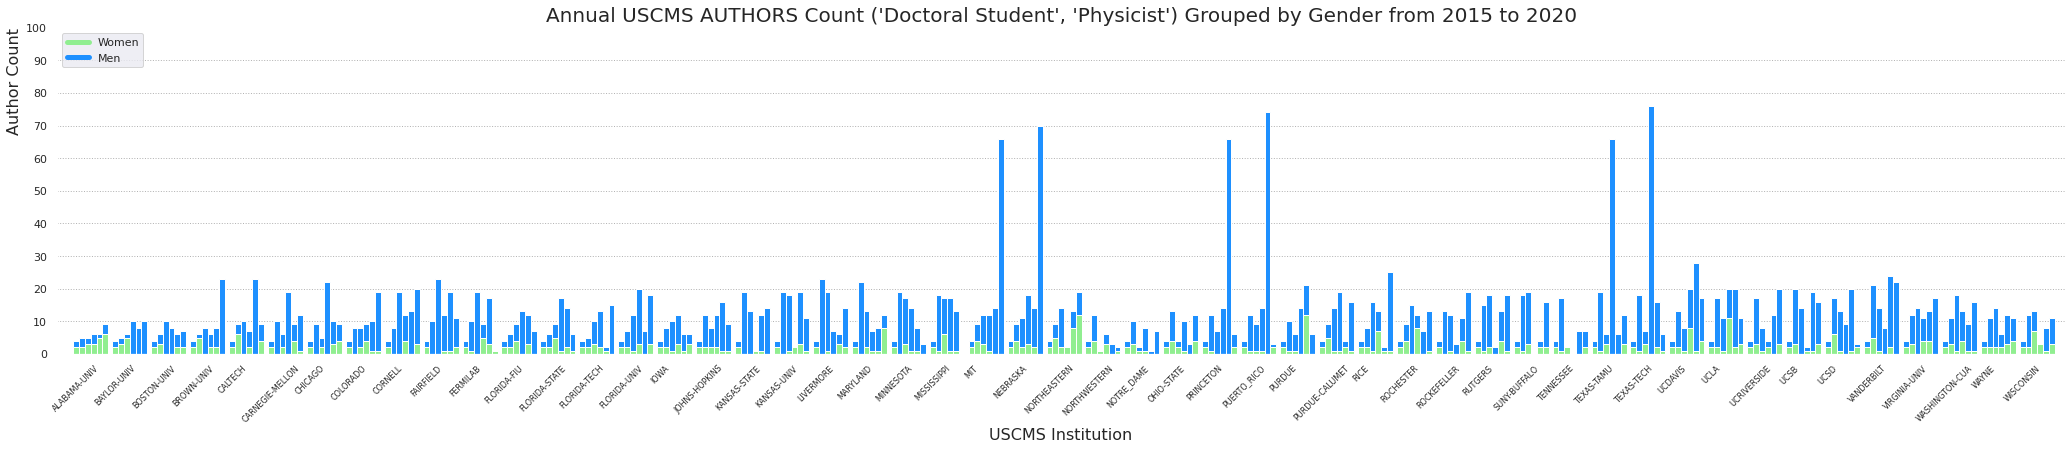

In [15]:
#@markdown Plot the author count grouped by intstitution and gender
labels = df2.variable.unique()
n_count = int( df2.value.count() / 2 )
x = np.arange( len( labels ) )
width = 0.9 / len( yearlist )
women_count = df2.value.to_numpy()[0:n_count]
men_count =   df2.value.to_numpy()[n_count:] - women_count
people = { "WOMEN": {}, "MEN": {} }
for i, year in enumerate( yearlist ):
  people[ "WOMEN" ][ year ] = []
  people[ "MEN" ][ year ] = []
  for j in range( int( n_count/len(yearlist) ) ):
    people[ "WOMEN" ][ year ].append( women_count[ ( j + 1 ) * i ] )
    people[ "MEN"   ][ year ].append( men_count[   ( j + 1 ) * i ] )

plt.figure( figsize = (36,6) )
ax = plt.subplot(111)

for i, year in enumerate( yearlist ):
  ax.bar( x + width*i, people[ "WOMEN" ][ year ], width, color = "lightgreen" )
  ax.bar( x + width*i, people[ "MEN"   ][ year ], width, bottom = people[ "WOMEN" ][ year ], color = "dodgerblue" )

ax.set_xlabel( "USCMS Institution", fontsize = 16 )
ax.set_xlim(-0.5,len(labels)+0.1)
ax.set_ylabel( "Author Count", y = 1.0, ha = "right", fontsize = 16 )
ax.set_ylim(0,100)
ax.set_title( "Annual USCMS {} Count {} Grouped by Gender from {} to {}".format( 
    members.value, category_list.value, yearlist[0], yearlist[-1] ),
    fontsize = 20 )
ax.set_xticks( x )
ax.set_yticks( np.linspace(0,100,11) )
ax.set_xticklabels( labels, rotation = 45, fontsize = 8 )

custom_legend = [
  Line2D( [0], [0], color = "lightgreen", lw = 5 ),
  Line2D( [0], [0], color = "dodgerblue", lw = 5 )
]
ax.legend( custom_legend, [ "Women", "Men" ], loc = 2 )
ax.set_facecolor("white")
ax.grid( b=True, which="major", axis="y", color = [0.7,0.7,0.7], linestyle = ":", linewidth = 1)
plt.show()

